In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [2]:
train_values = pd.read_csv('data/train_values.csv')
train_label = pd.read_csv('data/train_labels.csv')

In [3]:
# merge the two data frames
df = train_values.merge(train_label, on='id')

In [4]:
# check that all rows were in the joined dataset
len(df) == len(train_label) == len(train_values)

True

In [5]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [6]:
# search for duplicates 
df[df['id'].duplicated()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group


In [7]:
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['column', 'number of missing values']
missing[missing['number of missing values']>0]

,column,number of missing values
3,funder,3637
5,installer,3655
8,wpt_name,2
11,subvillage,371
18,public_meeting,3334
20,scheme_management,3878
21,scheme_name,28810
22,permit,3056


### Remove Unwanted Fields

In [8]:
# uneeded columns (fields that don't help predict the target label)
unneeded_col = ['id', 'recorded_by', 'wpt_name']
df = df.drop(unneeded_col, axis=1)



### Handling Fields with Too Many Unique Values

In [9]:
# get all categorical variables
df['region_code'] = df['region_code'].astype('object')
df['district_code'] = df['district_code'].astype('object')

cat_var = [col for col in df.columns if df[col].dtypes == 'object']
col_count = {}

# find number of unique values in each categorical variable
for col in cat_var:
    count = df[col].nunique()
    col_count[col] = count
col_count

{'date_recorded': 356,
 'funder': 1896,
 'installer': 2145,
 'basin': 9,
 'subvillage': 19287,
 'region': 21,
 'region_code': 27,
 'district_code': 20,
 'lga': 125,
 'ward': 2092,
 'public_meeting': 2,
 'scheme_management': 11,
 'scheme_name': 2695,
 'permit': 2,
 'extraction_type': 18,
 'extraction_type_group': 13,
 'extraction_type_class': 7,
 'management': 12,
 'management_group': 5,
 'payment': 7,
 'payment_type': 7,
 'water_quality': 8,
 'quality_group': 6,
 'quantity': 5,
 'quantity_group': 5,
 'source': 10,
 'source_type': 7,
 'source_class': 3,
 'waterpoint_type': 7,
 'waterpoint_type_group': 6,
 'status_group': 3}

In [10]:
# redundant data (fields with information provided in other columns)
redundant_col = ['subvillage','latitude', 'longitude', 'region_code', 'district_code', 'lga', 'ward', 'scheme_name', 'extraction_type', 'extraction_type_group', 'payment', 'water_quality', 'quantity', 'source', 'source_type', 'waterpoint_type']

df = df.drop(redundant_col, axis=1)

### Handle Fields with Missing Values

In [14]:
cat_var = [col for col in df.columns if df[col].dtypes == 'object']
col_count = {}

# find number of unique values in each categorical variable
for col in cat_var:
    count = df[col].nunique()
    col_count[col] = count
col_count

{'funder': 1896,
 'installer': 2145,
 'basin': 9,
 'region': 21,
 'public_meeting': 2,
 'scheme_management': 11,
 'permit': 2,
 'extraction_type_class': 7,
 'management': 12,
 'management_group': 5,
 'payment_type': 7,
 'quality_group': 6,
 'quantity_group': 5,
 'source_class': 3,
 'waterpoint_type_group': 6,
 'status_group': 3}

In [17]:
missing = pd.DataFrame(df.isnull().sum()/len(df)*100).reset_index()
missing.columns = ['column', '% missing values']
missing[missing['% missing values']>0]

,column,% missing values
1,funder,6.122896
3,installer,6.153199
8,public_meeting,5.612795
9,scheme_management,6.528620
10,permit,5.144781


### Handle Date Values

In [12]:
# derive age of water pump (i.e., years since construction)
df['construction_year'] = pd.to_datetime(df['construction_year'])
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['age'] = (df['date_recorded'] - df['construction_year']) / np.timedelta64(1, 'Y')

# delete construction_year and date_recorded columns 
df = df.drop(['construction_year', 'date_recorded'], axis=1)

In [26]:
# get quantifiable variables
num_var = [col for col in df.columns if df[col].dtypes in ['float64', 'int64']]
num_var

['amount_tsh', 'gps_height', 'num_private', 'population', 'age']

### Testing Numerical Features With ANOVA

,amount_tsh,gps_height,num_private,population,age,status_group
0,6000.0,1390,0,109,41.224658,functional


<Axes: >

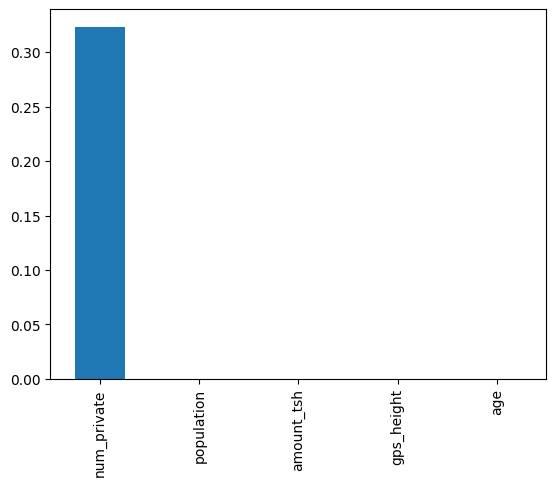

In [71]:
# copy the dataset for ANOVA test
df_int = df.copy(deep=True)

# keep the numerical columns and the target label
int_var = [col for col in df.columns if df[col].dtypes in ['int64', 'float64']] + ['status_group']
df_int = df_int[int_var]

# get the input and output variables
X = df_int.drop('status_group', axis=1)
y = df_int['status_group']

# compute the ANOVA F-statistic for each column
select = SelectKBest(f_classif, k=5)
fit = select.fit(X, y)

# compute the p-values for each F-statistic
p_values = {col: np.round(p_value, 4) for col, p_value in zip(X.columns, fit.pvalues_)}

p_values = pd.Series(p_values.values(),index = p_values.keys())
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

In [72]:
# columns with high p-values from ANOVA test
anova_drop = ['num_private']
df = df.drop(anova_drop, axis=1)

### Testing Categorical Features With Chi-Square Test

In [65]:
# copy the dataframe for chi square tests
df_chi = df.copy(deep=True)

# keep the categorical variables in the data frame
cat_var = [col for col in df_chi.columns if df[col].dtypes == 'object']
df_chi = df_chi[cat_var]

# encode the categorical variables
label_encoder = LabelEncoder()
for col in df_chi.columns:
    df_chi[col] = label_encoder.fit_transform(df_chi[col])

# get input and output variables
X = df_chi.drop('status_group',axis=1)
y = df_chi['status_group']

# perform chi-square tests
chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)


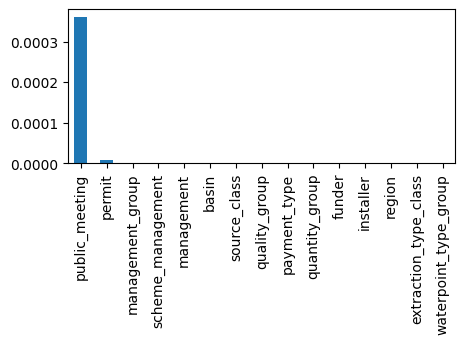

In [66]:
plt.figure(figsize=(5,2))
p_values.plot.bar()
plt.show()


In [74]:
df.shape

(59400, 20)

In [75]:
df.head(3)

,amount_tsh,funder,gps_height,installer,basin,region,population,public_meeting,scheme_management,permit,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_class,waterpoint_type_group,status_group,age
0,6000.0,Roman,1390,Roman,Lake Nyasa,Iringa,109,True,VWC,False,gravity,vwc,user-group,annually,good,enough,groundwater,communal standpipe,functional,41.224658
1,0.0,Grumeti,1399,GRUMETI,Lake Victoria,Mara,280,NaN,Other,True,gravity,wug,user-group,never pay,good,insufficient,surface,communal standpipe,functional,43.205479
2,25.0,Lottery Club,686,World vision,Pangani,Manyara,250,True,VWC,True,gravity,vwc,user-group,per bucket,good,enough,surface,communal standpipe,functional,43.180822
